In [1]:
import pandas as pd
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from functools import reduce
from itertools import accumulate
from functools import wraps
from sklearn.datasets import make_circles 
from mpl_toolkits.mplot3d import Axes3D 
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
from visualizacoes import display_vec, display_matrix, load_dataset, plot_decision_boundary, plot_single_clf

### Introdução

No notebook passado exploramos como um podemos transformar uma linha (ou seja, uma regressão) em um modelo de classificação através de uma __função de ativação__. Esse modelo inclusive, como agora sabemos, foi inspirado no neurônio humano, que deu luz ao neurônio articifial, o Perceptron. O Perceptron é capaz de modelar uma linha discriminatória que separa observações de diferentes classes:

<img src='imgs/linear_separable.png'>

Dados linearmente separáveis são casos mais convenientes de se classificar pois necessitamos de apenas um hiperplano  para separar tais classes, como na imagem acima. No entanto, o mundo nem sempre é tão colorido assim. Abaixo, criamos um dataset sintético, separados em duas classes (por cores distintas):

In [4]:
X, Y = make_circles(n_samples = 300, noise = 0.05, factor=.4) 

In [5]:
X.shape

(300, 2)

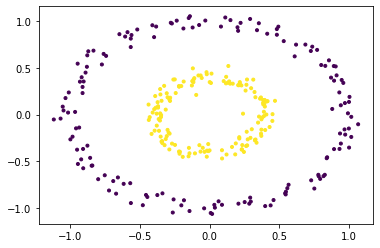

In [6]:
plt.scatter(X[:, 0], X[:, 1], c = Y, marker = '.') 
plt.show() 

Repare que no caso acima, não conseguiriamos traçar uma única linha que separe satisfatóriamente as classes. Por exemplo, abaixo definimos um perceptron com coeficientes já ajustados cuja classificação é dada por:

$$ \normalsize \hat{y} = \varphi(1.31 x_1 + 0.77 x_2)$$

Onde $\varphi$ é a __função de ativação__ do perceptron, que no caso mais simples, é uma __step function__ dada por:
<br><br>
$$ 
\normalsize 
\varphi(z) 
= 
\left\{\begin{matrix}
0 \text{    se } z \leqslant 0,
\\ 
1 \text{    se } z > 0,
\end{matrix}\right.
$$
<br><br>
Usamos a classe de Perceptrons definida no último notebook para criar esse modelo:

In [7]:
class Perceptron():
    
    def __init__(self, W=None, B=None, activation=lambda x: np.array([1 if z > 0 else 0 for z in x])):
        self.W = W
        self.bias = B
        self.g = activation
    
    def predict(self, X):
        """
        X: Numpy.array de dimensões (n_samples x n_features)
        retorna: Ativação do perceptron, dado por g(z)
        A ativação padrão é a step function, retornando 1 se o valor for maior que 0, senão 0
        """
        # realiza a função de soma Z = WX + B
        z = np.dot(X, self.W) + self.bias
        
        # retorna a ativação da somatória g(WX + B)
        return self.g(z)

In [8]:
perceptron = Perceptron(W=np.array([1.31, 0.77]), B=np.array([.0]))

Para avaliar o ajuste do perceptron aos dados de maneira visual, podemos plotar a __superfície de decisão__ do modelo e assim, ver a geometria do hiperplano encontrado. A ideia de utilizar um dataset de duas variáveis apenas foi intencional, pois os eixos de um plot de superfície de decisão são as variáveis independentes do modelo. Para gerar uma visualização 2D, precisamos de 2 features. A partir dessas features, aplicaremos o modelo para obter a classificação de todas as combinações $(x_{1i}, x_{2i})$  dentro do range de valores de $\text{max}(x_1), \text{max}(x_2)$. Após gerar a grade de cordenadas $(x_{1i}, x_{2i})$, precisamos aplicar o modelo nessa grade para retornar as classificações em cada coordenada. 

Criamos a função `plot_cortornos` para gerar a grade de coordenadas, gerar as previsões com o modelo, e retornar um plot contendo o contorno da superfície de decisão do modelo.


In [9]:
def plot_contornos(ax, clf, X, step=.02, **params):
    """
    Argumentos:
    ax = matplotlib.axes.Axes
    clf = classificador que contenha a função predict e retorne um numpy.array (n_samples, ) 
    X = Numpy.array de shape (n_samples x 2)
    step = argumento step da função np.arange(start, stop, step), o intervalo entre os valores gerados
    **params = kwargs da função ax.contourf
    
    retorna:
    plot da superfície de decisão do classificador para x1, x2
    """
    # computa tuplas contendo menor e maior valor para X1 e X2
    X1, X2 = list(map(lambda x: (x.min() - 1, x.max() + 1), [X[:, 0], X[:, 1]]))
    
    # gera grade de valores
    coords_x1, coords_x2 = np.meshgrid(np.arange(X1[0], X1[1], step), np.arange(X2[0], X2[1], step))

    # realiza as previsões para todas as coordenadas
    preds = clf.predict(np.c_[coords_x1.ravel(), coords_x2.ravel()]).reshape(coords_x1.shape)
    
    # retorna o plot da superfície de decisão
    return ax.contourf(coords_x1, coords_x2, preds, **params)

Agora, encapsulamos na função `plot_superficie_decisao` a execução da função acima, onde, em adição aos plots da superfície de decisão, serão plotados os dados de treino em si em uma matriz de dispersão. 

In [10]:
def plot_superficie_decisao(clf, X, Y, size=None, title='Superfície de Decisão'):
    """
    Argumentos:
    clf = classificador que contenha a função predict e retorne um numpy.array (n_samples, ) 
    X = Numpy.array de shape (n_samples x 2)
    Y = Numpy.array de shape (n_samples, 1)
    size = tupla contendo tamanho do plot em pixels que será passada em plt.subplots, padrão é None,
    title = Título do gráfico
    """
    # gera os subplots
    fig, ax = plt.subplots(figsize=size)
    
    # chama a função plot_contornos para plotar a superfície de decisão
    plot_contornos(ax, clf, X, cmap=plt.cm.coolwarm, alpha=0.5)
    
    # plota dos dados de treino na mesma figura
    ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.coolwarm, s=15, edgecolors="k")
    
    # define o título da visualização
    ax.set_title(title)
    
    # exibe o plot
    plt.show()

Chamando a função `plot_superficie_decisao` e exibindo o plot:

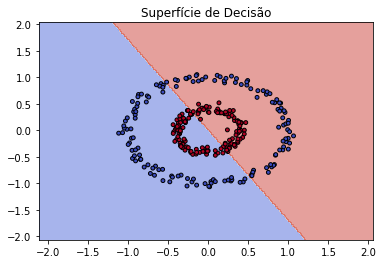

In [11]:
plot_superficie_decisao(perceptron, X, Y)

Perceba que uma única linha não é suficiente para desenhar uma superfície de decisão complexa como a que precisamos nesse caso para ter um classificador descente. Em caso de um dataset balanceado, teríamos uma acurácia também próxima a 50%: 

In [12]:
from sklearn.metrics import accuracy_score as acc

In [13]:
preds = perceptron.predict(X)

In [14]:
acc(Y, preds)

0.5133333333333333

### Superfícies de decisão não lineares

Vamos olhar novamente a distribuição dos dados. Não importa o quanto alteremos os valores de $w_1$, $w_2$ e $b_1$, nunca teremos nenhuma superfície de decisão que não seja linear, e já percebemos que superfícies de decisão lineares não são capazes de distinguir as duas classes nesse caso. Precisamos de alguma forma criar superfícies de decisão mais complexas do que hiperplanos. 

Uma das abordagens desenvolvidas para lidar com problemas não linearmente separáveis é a de combinar múltiplas linhas para poder desenhar superfícies de decisão mais elaboradas. No nosso caso, a grosso modo, vamos assumir que três classificadores em conjunto possam criar uma superfície de decisão complexa o suficiente para distinguir essas classes. Criamos então 3 Perceptrons, $P1, P2, P3$ para traçar esses 3 hiperplanos distintos, dados por:

(1) $$ \normalsize P_1 = \varphi(-24.8 x_1 -8.9 x_2 - 12.87) $$
<br><br>
(2) $$ \normalsize P_2 = \varphi(11.33 x_1 - 8.59 x_2 - 6.32) $$
<br><br>
(3) $$ \normalsize P_3 = \varphi(3.38 x_1 - 31.67 x_2 - 15.9) $$

Na célula abaixo, criamos esses perceptrons:

In [15]:
# Perceptron 1
W1 = np.array([-24.8, -8.9])
B1 = np.array([-12.87])
P1 = Perceptron(W1, B1)

# Perceptron 2
W2 = np.array([11.33, -8.58])
B2 = np.array([-6.32])
P2 = Perceptron(W2, B2)

# Perceptron 3
W3 = np.array([3.38, 31.67]) 
B3 = np.array([-15.90]) 
P3 = Perceptron(W3, B3)

Agora que temos 3 classificadores, plotamos os 3 hiperplanos e regiões de decisão encontrados

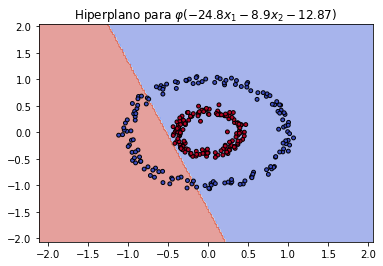

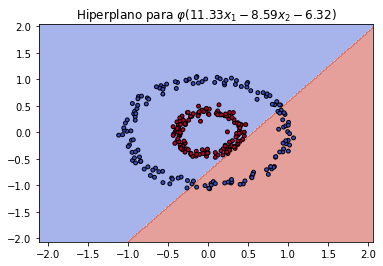

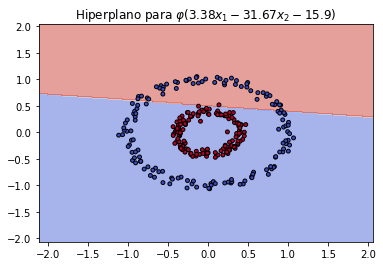

In [16]:
titulos = ['Hiperplano para $\\varphi(-24.8 x_1 -8.9 x_2 - 12.87)$',
           'Hiperplano para $\\varphi(11.33 x_1 - 8.59 x_2 - 6.32)$',
           'Hiperplano para $\\varphi(3.38 x_1 - 31.67 x_2 - 15.9)$']

for i, clf in enumerate([P1,P2,P3]):
    plot_superficie_decisao(clf, X, Y, title=titulos[i])

Acima podemos ver que, individualmente, nenhum dos Perceptrons faz um bom trabalho de classificação, muito pelo contrário, eles são até piores do que o primeiro modelo que mostramos. 

Entretanto, repare que, embora individualmente elas não sejam interessantes, cada uma destas superfícies de decisão encontram uma área de separação bastante interessante e próxima entre pontos da classe 1 (vermelho) e pontos externos da classe 0 (azul). Se utilizarmos estes 3 hiperplanos em conjunto, podemos triangular a classe 1 e separá-la da classe 0, criando uma superfície de decisão mais elaborada e ajustada aos dados

### Camada Oculta

Vamos voltar um pouco na intuição do Perceptron: Um perceptron como bem sabemos é uma tentativa de simular um neurônio humano através de cálculos matemáticos, onde os inputs representam os dendritos, a transferência de informação para esse neurônio se da pela multiplicação dos inputs pelos pesos $w$, e essa informação é o que faz um neurônio ativar ou não, e essa informação é transmitida a frente para os próximos neurônios. Em outras palavras, perceptrons simulam estruturas que são idealizadas para se __conectarem e comunicarem__ entre si, não a toa, possuímos bilhões de neurônios em nosso cérebro, não apenas um único. 

O que faremos, é aplicar essa mesma lógica aos nossos neurônios criados e construir uma rede de perceptrons, ou seja, um MultiLayer Perceptron. Mas vamos pensar nisso por partes. Estruturaremos a nossa rede de perceptrons em 3 camadas distintas. A primeira é a camada de __input__. Pense no seguinte, os três perceptrons que criamos e que precisamos conectar, recebem a __mesma informação de entrada__ correto? Logo, a primeira camada da nossa rede de perceptrons deve ser uma camada que envia a informação inicial para cada um dos perceptrons! A camada dos perceptrons será chamada de camada __oculta__. Podemos desenhar essa estrutura mais ou menos assim:

<img src='imgs/MLP_input_hiddenlayer.png' width='540px'>



### Funções de ativação mais elaboradas

Antes de estruturarmos a arquitetura acima, precisamos olhar com atenção para as funções de ativação dos neurônios, pois em um contexto de redes neurais, essas funções funcionam bem melhor durante a otimização de redes neurais. Os motivos disso ficaram muito mais claros a partir do próximo notebook onde abordaremos o processo inteiro de otimização de redes neurais. Nesse momento, vamos apenas introduzir as três funções de ativação mais associadas a redes neurais:

#### Sigmoid

A função <a href='https://en.wikipedia.org/wiki/Sigmoid_function'>sigmoide</a> gera uma curva em forma de S, tendo como menor valor 0, e maior valor 1. É uma função bastante popular, que serve além de tudo como base para outras funções como a __logística__ e a função tangente hiperbólica, que será revisada a seguir. Essa função é dada pela fórmula a seguir:

$$ \normalsize \text{sigmoid}(x) = \frac{1}{1 + e^{-x}} $$

Utilizando essa fórmula como ativação da transferência do perceptron, teremos:

(2) $$ \normalsize \text{sigmoid}(\sum w_i x_i + b) = \frac{1}{1 + e^{-(\sum w_i x_i + b)}} $$

Criamos abaixo a função sigmoide:

In [17]:
# para facilitar a associação entre as equações e o código, atribuímos a função exponencial do pacote numpy 
# à variável "e" de Euler
e = np.exp

def sigmoid(x):
    """
    Argumentos:
    X = Numpy.array
    
    retorna:
    Função sigmoide 1 / 1 + e^-X
    """
    return 1 / (1 + e(-x))

Agora faremos um plot para exibir a função sigmoide para exibir a famosa curva em forma de S desta função. Repare abaixo que quando $X$ tende a $\infty$, a função tende à 1, quando $X$ tende à $-\infty$, a função tende a 0:

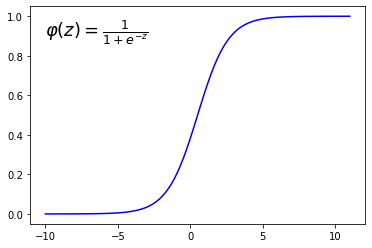

In [18]:
graph = plt.plot(np.linspace(-10,11,100), sigmoid(np.linspace(-10,10,100)), color='blue')
p = plt.text(-10, .9, r'$\varphi(z) = \frac{1}{1 + e^{-z}}$', fontsize=18)

A sigmoide foi uma das primeiras melhorias no estudo das funções de ativação de perceptrons e redes neurais. Ela acabou substituindo as step functions durante muito tempo por ser uma função __contínua__ e __diferenciável__ quando $x = 0$. Existem motivos matemáticos muito relevantes para que essas características tornem a função sigmoide uma função muito mais interessante para redes neurais do que a step function. Novamente, esses motivos serão perfeitamente esclarecidos no próximo notebook, onde estudaremos a fundo o processo de aprendizagem de redes neurais. 

Para o nosso exemplo, utilizaremos a função sigmoide como ativação do neurônio de saída, o perceptron $P_4$. Diferente da Step function, a sigmoide retorna um valor contínuo,e para gerar uma classificação, precisamos definir um threshold, uma nota de corte: qualquer valor acima dele receberá a classificação 1, caso contrário 0. Por padrão, colocamos o threshold em 0.5, sendo assim, a função de decisão é dada por:

<br>
$$ 
\normalsize 
\varphi(z) 
= 
\left\{\begin{matrix}
1 \text{    se } g(z) \geq  0.5,
\\ 
0 \text{    caso contrário } 
\end{matrix}\right.
$$
<br>

#### Tanh

Uma das variações mais comuns da sigmoide, que também é utilizada bastante em redes neurais, é a função __tangente hiperbólica__, normalmente abreviada para <em>tanh</em>. Ela gera uma curva de S mais achatada, e sua imagem está entre -1 e 1 ao invés de 0 e 1. A função é dada pela fórmula:

$$ \normalsize \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $$

Abaixo criamos a função:

In [19]:
def tanh(x):
    """
    Argumentos:
    x = Numpy.array
    
    retorna:
    Função tangente hiperbólica 
    """
    return (e(x) - e(-x)) / (e(x) + e(-x))

Abaixo geramos o plot da função `tanh`:

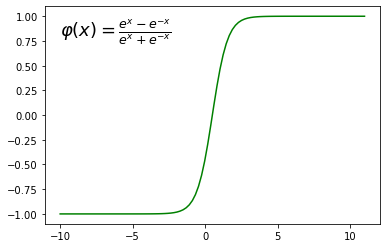

In [20]:
graph = plt.plot(np.linspace(-10,11,100), tanh(np.linspace(-10,10,100)), color='green')
p = plt.text(-10, .8, r'$\varphi(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$', fontsize=18)

Usualmente, para criar uma superfície de decisão a partir da função Tanh, usamos a mesma abordagem que a sigmoide, definindo um threshold de decisão, com a diferença que no caso da Tanh usamos:

<br>
$$ 
\normalsize 
\varphi(z) 
= 
\left\{\begin{matrix}
1 \text{    se } g(z) \geq  0,
\\ 
0 \text{    se } g(z) < 0
\end{matrix}\right.
$$
<br>


#### ReLU 

Mais recentemente, especialmente devido aos avanços nos estudos de __deep learning__, uma nova função de ativação se mostrou mais útil do que a sigmoide em muitos casos, a Rectified Linear Unit, abreviada para ReLU. Essa função é assim como a sigmoide e tanh, diferenciável em todos os pontos, mas tem um comportamento bem específico. Ela funciona como uma função identidade normal (ou seja, retorna o próprio valor), quando este for maior que zero, caso contrário, a função simplesmente retorna zero. Podemos expressar a ReLU como:

$$ \normalsize \text{ReLU}(x) = \max(0, x) $$

Podemos dizer que a ReLU é quase uma step function, com a diferença de que ela retorna o valor em si caso ele seja maior que zero, ao invés de apenas 1. E ReLU de uma certa forma, resolve muitos dos problemas de aprendizado da rede neural associados a sigmoide e step. Um problema no entanto ainda persiste com a ReLU, mas que foi depois solucionado com a função __Leaky ReLU__, que cobriremos também no próximo notebook.

Abaixo criamos a função `ReLU`:

In [21]:
def ReLU(x):
    """
    Argumentos:
    x = Numpy.array
    
    retorna:
    Função Rectified Linear Unit
    """
    return np.array([max(0, i) for i in x])

E agora, exibimos o plot da função `ReLU`

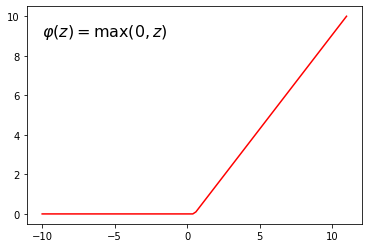

In [22]:
graph = plt.plot(np.linspace(-10,11,100), ReLU(np.linspace(-10,10,100)), color='red')
p = plt.text(-10, 9, r'$\varphi(z) = \max(0, z)$', fontsize=16)

Repare no comportamento da função ReLU. Ela "ativa" o neurônio apenas para valores maiores que zero, e "desativa" caso contrário. Esse é um comportamento especialmente interessante para neurônios nas camadas internas de uma rede neural por muitos motivos. 

### Construção do modelo

Agora que introduzimos o conceito de redes de perceptrons, além das três funções de ativação mais utilizadas em multilayer perceptrons, temos todos os insumos necessários para construir de maneira compreensiva a rede de perceptrons descrita no problema desse notebook, que deve ser capaz de desenhar uma superfíce de decisão conjunta dos três perceptrons. Aqui seguiremos uma abordagem bastante comum e didática de se codificar redes neurais, onde representamos neurônios, ou mesmo layers como objetos de classes específicas, e após isso podemos construir a arquitetura da rede como uma lista de objetos.

A camada de __input__ da rede não será criada, pois ela é mais teórica do que física nesse caso. Precisamos garantir apenas que os inputs sejam devidamente enviados para cada um dos perceptrons na camada oculta. Vamos então compor primeiro a camada oculta de perceptrons. Já temos todos os pesos (`W1`, `W2`, `W3`) e bias (`B1`, `B2`, `B3`) armazenados em variáveis para criar cada um dos neurônios. Porém, precisamos fazer uma alteração em relação aos primeiros perceptrons notebook acima: eles não são mais classificadores individuais, mas sim neurônios intermediários, e por isso, mantê-los com sua ativação de step function padrão não seria interessante. 

Abaixo, exibimos como seria essa transformação $T:\mathbb{R}^2 \rightarrow \mathbb{R}^3$ para o nosso input $X$ que está em $\mathbb{R}^2$ para um vetor em $\mathbb{R}^3$ com neurônios ativados por step function para os 4 primeiros samples:
<br><br><br>
$$ 
\normalsize
\begin{vmatrix}
0.62 & 0.84\\ 
-0.33 & 0.21\\ 
0.39 & -0.84\\ 
0.61 & 0.65
\end{vmatrix}
\rightarrow 
\begin{bmatrix}
0 & 0 & 1\\ 
0 & 0 & 0\\ 
0 & 1 & 0\\ 
0 & 0 & 1
\end{bmatrix}
$$

#### Possível perda de informação 

Perceba que transformamos vetores de valores contínuos em vetores binários em $\mathbb{R}^3$. Embora isso não impeça em nada a transmissão da informação para os próximos neurônios, uma representação binária raramente será mais informativa do que uma representação contínua, ao menos em um contexto de redes neurais. Embora a informação seja representada em mais dimensões, essas dimensões em si representam apenas informações binárias (0 ou 1). Isso pode não ser um problema em casos extremamente simples, como os casos didáticos de operadores AND, OR, XOR por exemplo, mas na vida real, essa representação binária pode acarretar em perda de informação das variáveis originais, e consequentemente, os perceptrons a frente na rede terão pouca informação para trabalhar e classificar também. 

#### Stepfunction não é diferenciável para x = 0

Embora a possível perda de informação causada pela STEP function possa atrapalhar a classificação de conjuntos de dados mais complexos, não é esse o grande impeditivo de utilizá-la para redes neurais, por exemplo, neste caso, conseguiríamos um classificador igualmente bom. O que realmente atrapalha é o fato da step function não ser contínua, e em específico, não é diferenciável quando o valor de $x$ é igual a 0. O problema é que o algoritmo que usamos para ajustar o pesos da rede depende justamente de funções de ativação contínuas e diferenciáveis para a aprendizagem dos neurônios!

Novamente, não se preocupe se esse conceito ainda estiver nebuloso, todo esse cenário ficará claro como o dia quando abordarmos os algoritmos de aprendizado de redes neurais no próximo notebook, por enquanto estamos apenas preparando o terreno para o que veremos a seguir.

O que faremos então é criar a camada oculta de perceptrons usando como ativação a `ReLU` ao invés da step function padrão

In [23]:
camada_oculta = [
    Perceptron(W1, B1, ReLU), 
    Perceptron(W2, B2, ReLU), 
    Perceptron(W3, B3, ReLU)
]

#### Data Transformation

Ao passarmos os inputs pela camada de perceptrons, estamos transformarndo um input bi-dimensional (duas variáveis $x_1$ e $x_2$) em um output tri-dimensional composto por $P_1$, $P_2$, $P_3$, ou seja, uma transformação linear:

$$ \normalsize T:\mathbb{R}^2 \rightarrow \mathbb{R}^3 $$

Essa transformação é então somada ao bias e passada por uma função não linear tal como a sigmoide:

$$ \normalsize \varphi(T(x) + b) $$

O que é equivalente a:

$$ \normalsize \varphi(Wx + b) $$

Transformação de dados originais (chamado de __input space__) em espaços dimensionais chamados __feature space__ é extremamente comum em machine learning, pois muitas vezes conseguimos separar dados linearmente inseparáveis projetando os mesmos em espaços dimensionais maiores onde estes são linearmente separáveis. Talvez o exemplo mais popular destas transformações seja o truque de kernel ("Kernel Trick") em Máquinas de Suporte Vetorial, uma outra classe de algoritmos supervisionados. Para problemas linearmente separáveis, SVMs funcionam de maneira muito semelhante a redes neurais sem ativações não lineares, encontrando o hiperplano $WX + b$ que maximiza a margem entre os data samples mais próximos entre as duas classes (estes chamados de vetores de suporte). Já quando os dados não saõ linearmente separáveis, esse algoritmo utiliza um funções pré-definidas chamadas de __kernels__ (RBF, polinomial, linear, etc) para mapear o input space em um espaço dimensional aumentado e a partir disso encontrar um hiperplano de separação. O interessante é que esse hiperplano encontrado na feature space assume justamente a forma da superfície de decisão complexa que queremos quando projetado no espaço dimensional original:

<br><br>
<img src='https://www.bogotobogo.com/python/scikit-learn/images/svm2/kernel-method-nonlinear-svm.png' width='500px'>
<br><br>

Voltando para nosso contexto, a camada oculta que criamos funciona exatamente como um kernel na rede neural. Veremos abaixo que o que a camada oculta está fazendo é justamente mapear as duas variáveis originais $x_1$ e $x_2$ em um espaço dimensional em $\mathbb{R}^3$. A rede neural, esta criando assim uma representação única e abstrata n-dimensional das variáveis originais, onde a informação original é transformada linearmente através dos pesos e depois não linearmente através do bias e da ativação.

Dito tudo isso, vamos codificar e simular tudo o que explicamos acima. Já criamos uma lista de perceptrons que representa a camada oculta da rede neural que estamos construindo. A função `feedforward` abaixo propaga a matriz de inputs (n_samples x n_features) pela camada oculta que criamos. Essa função poderia ser escrita em uma única linha, mas vamos fazer um código menos performático mas mais didático, para deixar bem legível o que estamos fazendo aqui:

In [111]:
def feedforward(X, layer):
    """
    X: Numpy.array de dimensões (n_samples x n_features)
    layer: objeto de perceptrons 
    
    Retorna:
    matriz de ativações (n_samples, n_neurons)
    """
    # cria matriz de zeros com shape (n_samples, n_neurons)
    ativacoes = np.zeros(shape=(X.shape[0],len(camada_oculta)))
    
    # Loop para interar sobre cada sample da matriz de input
    for i, _input_ in enumerate(X):
        
        # cria um vetor de zeros onde armazenamos as ativações de cada perceptron
        ativacao = np.zeros(len(layer)) 
        
        # Loop para interar sobre cada perceptron do layer
        for j, neuron in enumerate(layer):
            
            # computa a ativação do perceptron para o input x: A = g(Wx + b)
            ativacao[j] = neuron.predict(_input_)
            
        # armazena o vetor de ativações para o samples i
        ativacoes[i] = ativacao
    
    # retorna a matriz de ativações
    return ativacoes

In [112]:
ativacao_camada_oculta = feedforward(X, camada_oculta)

In [113]:
display_matrix(X, n_rows=7, label='x')
display_matrix(ativacao_camada_oculta, n_rows=7, label='\\varphi(Wx + b)')

<br>$x = \begin{bmatrix}-0.40&-0.17\\0.12&-0.43\\-0.91&0.29\\-0.12&0.36\\-0.57&0.72\\0.91&0.42\\-0.98&-0.24\end{bmatrix}$<br><br>

Dimensões da matriz: (300 x 2)



<br>$\varphi(Wx + b) = \begin{bmatrix}0&0&0\\0&0&0\\7.12&0&0\\0&0&0\\0&0&5.04\\0&0.40&0.44\\13.64&0&0\end{bmatrix}$<br><br>

Dimensões da matriz: (300 x 3)




Abaixo, plotamos visualizações para ver o que acontece com os dados quando eles são propagados pela camada oculta. A função `tridimensional_plot` trata de realizar essse plot:

In [25]:
from mpl_toolkits.mplot3d import Axes3D

def tridimensional_plot(triD_array, classes, size=(10,8)):
    # Cria a figura e subplot
    fig = plt.figure(figsize=(10,8))
    
    # cria um eixo tridimensional
    ax = fig.add_subplot(111, projection='3d')
    
    # projeta os dados tridimensionais mapeados com suas respectivas classes
    ax.scatter(
        triD_array[:, 0], 
        triD_array[:, 1], 
        triD_array[:, 2], 
        c=classes, 
        marker='o'
    )
    # defíne o rótulo dos eixos
    ax.set_xlabel('P1')
    ax.set_ylabel('P2')
    ax.set_zlabel('P3')
    
    # exibe o plot
    plt.show()

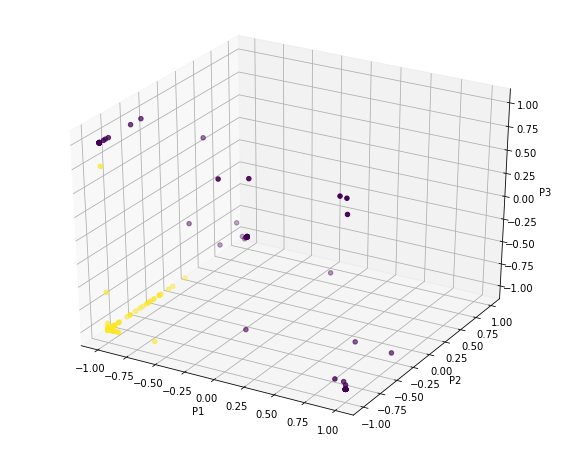

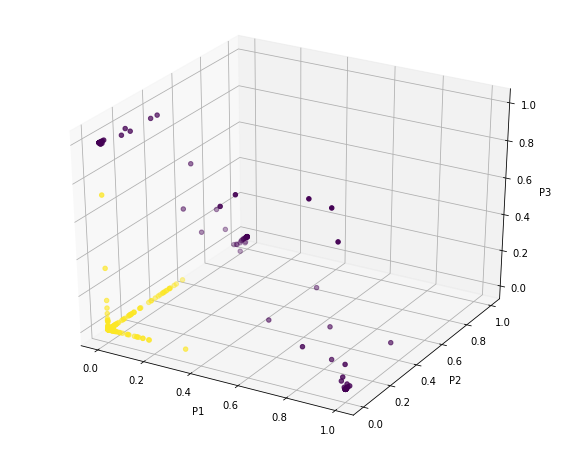

In [141]:
tridimensional_plot(tanh(z), Y)
tridimensional_plot(sigmoid(z), Y)

Input space: 


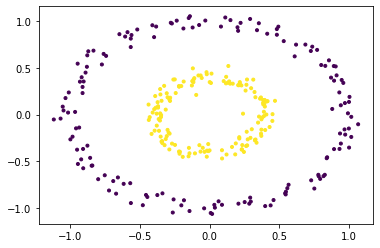

Transformação dos inputs com Wx + b: 


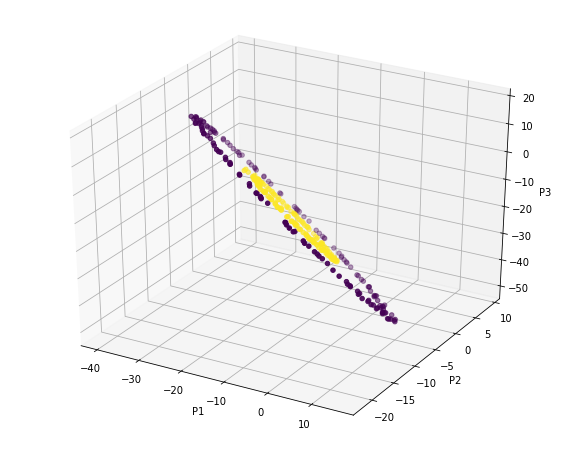

Feature space criado pelo Hidden Layer: 


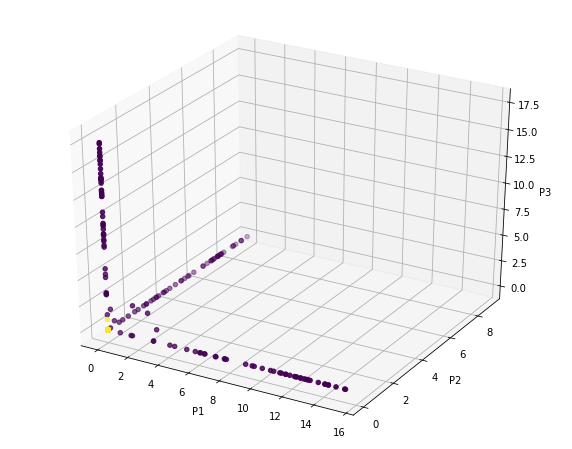

In [137]:
print('Input space: ')
plt.scatter(X[:, 0], X[:, 1], c = Y, marker = '.') 
plt.show() 
print('Transformação dos inputs com Wx + b: ')
z = np.dot(X, np.vstack([W1, W2, W3]).T) + np.vstack([B1, B2, B3]).reshape(-1)
tridimensional_plot(z, Y)
print('Feature space criado pelo Hidden Layer: ')
tridimensional_plot(ativacao_camada_oculta, Y)

Input space: 


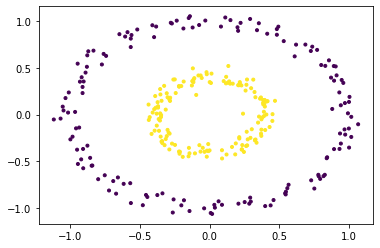

Transformação dos inputs com Wx + b: 


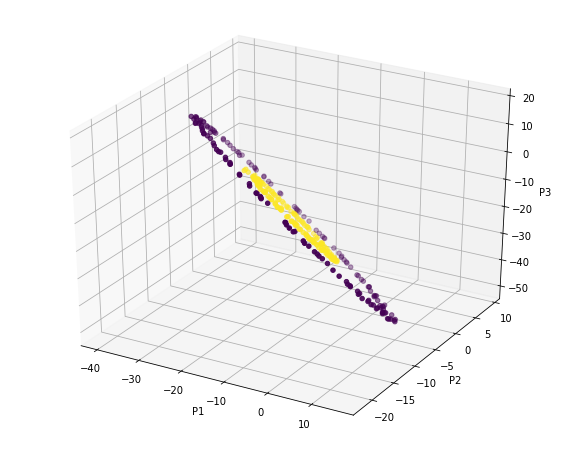

Feature space criado pelo Hidden Layer: 


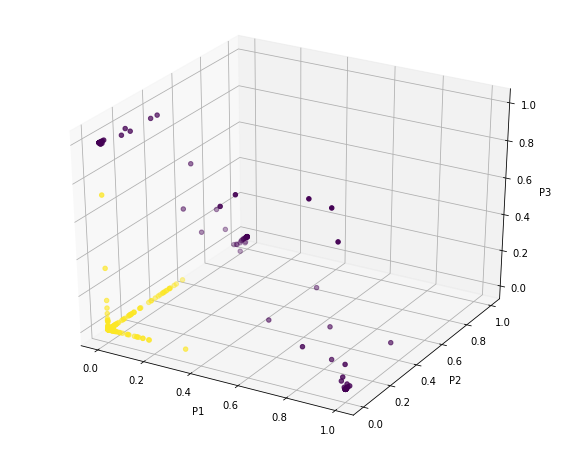

In [140]:
L = [
    Perceptron(W1, B1, sigmoid), 
    Perceptron(W2, B2, sigmoid), 
    Perceptron(W3, B3, sigmoid)
]
ativacao_teste = feedforward(X, L)
print('Input space: ')
plt.scatter(X[:, 0], X[:, 1], c = Y, marker = '.') 
plt.show() 
print('Transformação dos inputs com Wx + b: ')
z = np.dot(X, np.vstack([W1, W2, W3]).T) + np.vstack([B1, B2, B3]).reshape(-1)
tridimensional_plot(z, Y)
print('Feature space criado pelo Hidden Layer: ')
tridimensional_plot(ativacao_teste, Y)

#### Camada de saída

Temos agora uma rede de perceptrons que transforma um espaço bi-dimensional de features em uma feature space tri-dimensional perceptron na camada oculta. Mas ainda não temos um classificador, temos apenas as saídas originais dos três perceptrons. Precisamos de alguma forma transformar as saídas dos perceptrons em uma única classificação por input.

Para isso vamos conectar um __novo perceptron__, que recebe os inputs dos 3 perceptrons da camada oculta, e cria um classificador a partir destes inputs. Basicamente, o que queremos aqui é um perceptron a mais que interpreta a classificação dos 3 perceptrons anteriores, e gera uma única classificação com base nestes inputs. É mais ou menos como se estivessemos fazendo a classificação de um ponto com base em 3 perspectivas distintas ao invés de uma apenas. Repare abaixo também, que como qualquer perceptron, é atribuído um __peso__ $w$ a cada conexão de input:

<img src='imgs\MLP_input_hiddenlayer_final.png' width='750px'> 

Com isso, chegamos a uma arquitetura de Multilayer Perceptrons, que contem camadas de input, output, e ao menos uma camada oculta. Essa é a arquitetura base para todos os desenvolvimentos que surgiram no campo de deep learning nos últimos anos. A partir de um MLP simples como esse que iremos construir daqui a pouco, surgiram as redes profundas sofisticadas que estão sendo utilizadas exaustivamente no âmbito científico e industrial até o momento. 

In [57]:
W4 = np.array([-31.39, -23.13, -13.36])
B4 = np.array([[10.73]])

In [88]:
O = Perceptron(W4, B4, sigmoid)

In [94]:
O.predict(ativacao_camada_oculta)

array([9.99978122e-001, 9.99978122e-001, 3.64328207e-093, 9.99978122e-001,
       2.55794696e-025, 1.22667968e-002, 5.61098150e-182, 9.99978122e-001,
       3.42911414e-069, 9.99978122e-001, 2.15763018e-173, 3.21478180e-086,
       2.20402528e-097, 3.12836123e-094, 4.88484421e-016, 9.99978122e-001,
       4.02341206e-054, 9.99978122e-001, 9.99978122e-001, 9.99978122e-001,
       9.99978122e-001, 7.05124511e-048, 9.99978122e-001, 9.99978122e-001,
       1.43614345e-161, 6.99462519e-077, 9.99978122e-001, 9.99978122e-001,
       5.57466041e-066, 9.99978122e-001, 9.99978122e-001, 9.99978122e-001,
       3.73762021e-066, 2.83342998e-038, 1.08645099e-019, 9.30363113e-097,
       8.65721004e-167, 9.99978122e-001, 7.52203665e-067, 9.99978122e-001,
       1.34981982e-014, 9.99978122e-001, 3.88017787e-017, 9.99978122e-001,
       9.99978122e-001, 2.56720747e-150, 9.99978122e-001, 9.99978122e-001,
       2.72475354e-007, 1.00859207e-126, 9.99978122e-001, 9.99978122e-001,
       9.99978122e-001, 2

In [87]:
ativacao_output = feedforward(ativacao_camada_oculta, O).reshape(-1)

In [ ]:
def predict(ativacoes):
    

In [30]:
class Classificador(object):
    
    def __init__(self, hiddenLayer, outputLayer):
        self.hiddenLayer = hiddenLayer
        self.outputLayer = outputLayer    

    def feedforward(self, _input_):
        ativacoes = np.array([neuron.predict(_input_) for neuron in self.hiddenLayer]).T
        output = self.outputLayer[0].predict(ativacoes).T.reshape(-1)
        return output
        
    def predict(self, X):
        output = self.feedforward(X)
        return np.array([1 if a >= 0.5 else 0 for a in output])

In [32]:
clf = Classificador(camada_oculta, O)

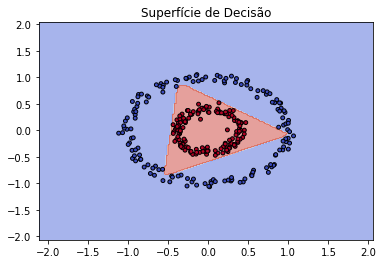

In [152]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(3,), solver='lbfgs', activation='logistic')
mlp.fit(X, Y)
plot_superficie_decisao(mlp, X, Y)

In [158]:
mlp.coefs_

[array([[-29.9189139 ,  16.54151556,  44.39812814],
        [  3.04034909,  23.0689689 , -88.83503272]]),
 array([[-19.00859004],
        [-20.62138435],
        [-23.33058216]])]

In [154]:
mlp.intercepts_

[array([-13.89098454, -14.97501071, -52.50532271]), array([10.27123575])]

In [225]:
# Perceptron 1
W1 = np.array([-29.9, 3.04])
B1 = np.array([-13.8])
P1 = Perceptron(W1, B1, sigmoid)

# Perceptron 2
W2 = np.array([16.5, 23.06])
B2 = np.array([-14.97])
P2 = Perceptron(W2, B2, sigmoid)

# Perceptron 3
W3 = np.array([ 44.39, -88.83]) 
B3 = np.array([-52.50]) 
P3 = Perceptron(W3, B3, sigmoid)

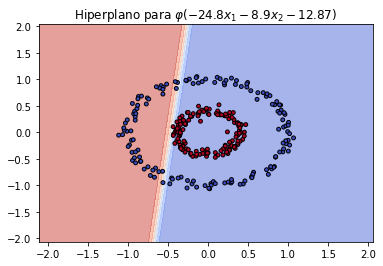

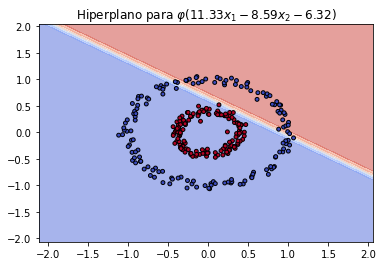

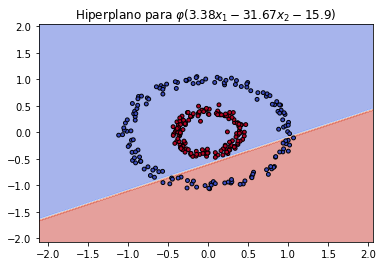

In [226]:
titulos = ['Hiperplano para $\\varphi(-24.8 x_1 -8.9 x_2 - 12.87)$',
           'Hiperplano para $\\varphi(11.33 x_1 - 8.59 x_2 - 6.32)$',
           'Hiperplano para $\\varphi(3.38 x_1 - 31.67 x_2 - 15.9)$']

for i, clf in enumerate([P1,P2,P3]):
    plot_superficie_decisao(clf, X, Y, title=titulos[i])

In [ ]:
W4 = np.array([-31.39, -23.13, -13.36])
B4 = np.array([[10.73]])

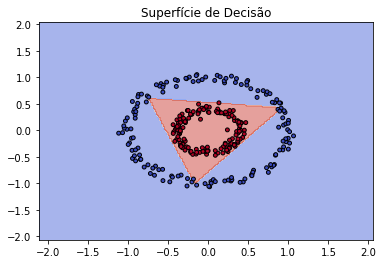

In [33]:
plot_superficie_decisao(clf, X, Y)

In [34]:
preds = clf.predict(X)

In [35]:
acc(Y, preds)

0.99

# MultiLayer Perceptron

<img src='https://www.learnopencv.com/wp-content/uploads/2017/10/mlp-diagram.jpg' width='600px'>

Podemos escrever a trasferência (somatória) do neurônio $k$ da camada $l$ de $z^{l}_{k}$ apenas adaptando um pouco a equação do perceptron simples adicionando a notação de índice das camadas de neuronios e substituindo $x$ por $a$ uma vez que o input de um neurônio da camada $l$ são as ativações $a$ dos neurônios da camada $l-1$:

$$ \normalsize z^{l}_{k} = \sum_{i=1}^{m} w^{l}_i a^{l - 1}_i + b^{l}_k $$ 

E a ativação do neurônio $z^{l}_{k}$ é dado por:

$$ \normalsize a^{l}_{k} = \sigma(z^{l}_{k}) $$


Quanto à camada de saída de uma rede neural, temos algumas coisas a se pensar. Podemos ter duas situações: classificação __binária__ (duas classes, como 0 e 1) ou __multiclasses__ (como, 1,2,3 ou mesmo, "gato", "cachorro", "pessoa", etc). Dependendo do caso, podemos optar por apenas um neurônio de saída (que geralmente terá ativação sigmoide/logística ou step), ou, caso tenhamos mais do que duas classes, podemos trabalhar com a função __softmax__, que é uma adaptação vetorial da função sigmoide que comporta múltiplas classes.

Supondo que ao invés de ter um neurônio de saída, tenhamos $K$ neurônios, um para cada uma das $k$ classes possíveis. Seja $\vec{a}$ um vetor contendo a ativação dos $k$ neurônios de saída, podemos utilizar a função softmax da seguinte forma:

(1) $$ \normalsize \vec{a} = \begin{bmatrix}a_1\\ a_2\\ \vdots\\ a_k\end{bmatrix} $$

a função softmax é dada por:

(2) $$ \normalsize \text{softmax}(\vec{a}) = \frac{e^{a_i}}{\sum_{j=1}^{k} e^{a_j}} $$

Como resultado, teremos um vetor de 0 a 1 que pode ser interpretado como a __probabilidade__ para cada classe:

(3) $$ \normalsize \text{softmax}(\vec{a}) = \begin{bmatrix}P(a_1|\vec{a})\\ P(a_2|\vec{a})\\ \vdots\\ P(a_k|\vec{a})\end{bmatrix} $$

Sendo assim, a classificação é dada pela classe com maior probabilidade:

(4) $$ \text{argmax}(\text{softmax}(\vec{a})) $$

Vamos ver um exemplo com um vetor $\vec{a}$  aleatório:

In [ ]:
class LinearLayer():
    
    def __init__(self, input_shape, n_neurons, activation):
        self.n_inputs = input_shape
        self.n_outputs = n_neurons
        self.weights = np.random.rand(input_shape, n_neurons)
        self.bias = np.random.rand(n_neurons)
        self.erro = None
        self.z = None
        self.a = None
        self.func = activation
        self.n_params = reduce((lambda x, y: x * y), self.weights.shape) + n_neurons
    
    def transfer(self, X):
        self.z = np.dot(X, self.weights) + self.bias
        self.a = self.func(self.z)

In [128]:
np.random.rand(3).shape

(3,)